# Explanability: 

## A contrastive Study of a Decision Tree (WhiteBox) versus a BiLstm (BlackBox):

## Table of Contents:

* [Explainability](#explain)
* [Dataset](#data)
* [Decision Tree](#decision_tree)
* [Concrete Example](#concrete_example)
* [BiLSTM](#biLSTM)
* [Application](#application)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


# Read in the train, test data
X_read = pd.read_csv('train_data_fix.csv')
y_read = pd.read_csv('train_results.csv')
X_test_read = pd.read_csv('test_data_fix.csv')

# Narrow the dataset down to the "text" or "target" columns.
X = X_read['text'].copy()
y = y_read['target'].copy()
X_test = X_test_read['text'].copy()


# High-level look at the dataset:
print(f'dataset sizes:')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'\ncomposition and distribution of y:')
print(f'y.value counts:\n {y.value_counts(normalize=True)}')


# The target data are almost evenly split between positive and negative, with barely any neutral.

# # Preprocessing

# #### Encode the target values as numbers



le = LabelEncoder()
le.fit(y.unique())
y = le.transform(y) #positive:2, negative:0, neutral:1
y[:5]


# #### Remove punctuation and numbers


def strip_punctuation(text):
    """
    Removes punctuation, digits, single characters and internet-stuff (url, html tags) from a string.
    """
    import re
    import string
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  # remove most punctuation
#     text = text.translate(str.maketrans('','', string.punctuation)) # backup remove most punctuation
    text = text.translate(str.maketrans('', '', string.digits)) # remove digits
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Removes url
    text = re.compile(r'<[^>]+>').sub('', text) #Removes HTML tags:
    text = re.sub(r'\b\w{1}\b', '', text) #re.sub(r"\s+[a-zA-Z]\s+", ' ', text) # Single character removal 
    text = re.sub(r'\s+', ' ', text) # Remove multiple spaces
    return text



# Preprocess both train and test data
X = X.apply(lambda x: strip_punctuation(x))
X_test = X_test.apply(lambda x: strip_punctuation(x))
X


# #### Stem


def stem_text(text, stemmer):
    stemmed_text = ''
    
    if stemmer == 'porter':
        from nltk.stem import PorterStemmer 
        st = PorterStemmer()
    elif stemmer == 'snowball':
        from nltk.stem import SnowballStemmer
        st = SnowballStemmer('english')

    for word in text.split(' '):
        stemmed_text += st.stem(word) + " "
        
    return stemmed_text[:-1]


# Stem data with snowball stemmer
X = X.apply(lambda x: stem_text(x, 'snowball'))
X_test = X_test.apply(lambda x: stem_text(x, 'snowball'))
X


# #### TFIDF Vectorizer


# Vectorize test data
tfvectorizer = TfidfVectorizer(min_df = 1e-6, ngram_range = (1,5), stop_words = None, 
                            lowercase =  True, use_idf= True, sublinear_tf = True)



# Train the vectorizer on the training data and transform the training data and the test data
X_bag = tfvectorizer.fit_transform(X)
print(f'X_bag.shape: {X_bag.shape}')
X_test_bag = tfvectorizer.transform(X_test)


# Train test split the word bag
X_train, X_val, y_train, y_val = train_test_split(X_bag,y, train_size = 0.7, random_state=42)
#See what the resulting size of the train test split is
print(f'X_train shape: {X_train.shape}')

dataset sizes:
X shape: (1040323,)
y shape: (1040323,)
X_test shape: (560175,)

composition and distribution of y:
y.value counts:
 positive    0.500264
negative    0.499655
neutral     0.000081
Name: target, dtype: float64
X_bag.shape: (1040323, 2347985)
X_train shape: (728226, 2347985)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import time
start_time = time.time()
clf_decision_tfidf = DecisionTreeClassifier(random_state=2)
clf_decision_tfidf.fit(X_train[0:200000], y_train[0:200000])
print("Time to taken to fit the TF-IDF as input for classifier: " + str(time.time() - start_time))

Time to taken to fit the TF-IDF as input for classifier: 3934.720956325531


In [ ]:
from sklearn import metrics
y_pred=clf_decision_tfidf.predict(X_val)
print(y_pred)
#rbf.score(X_val, y_val)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

[2 2 0 ... 2 0 2]
Accuracy: 0.7092858950903085


In [ ]:
y_out=clf_decision_tfidf.predict(X_test_bag)

In [ ]:
y_out.shape

(560175,)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rbf = RandomForestClassifier(n_estimators=1)
rbf.fit(X_train[0:100], y_train[0:100])

RandomForestClassifier(n_estimators=200)

In [ ]:
RF_clf = RandomForestClassifier(
    criterion="gini", max_depth=200, n_estimators=100
)  # initialise your random forest classifier
RF_clf.fit(X_train, y_train)

In [ ]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
y_pred=rbf.predict(X_val)
print(y_pred)
#rbf.score(X_val, y_val)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

In [ ]:
count = 0 
with open('_without_ft_fit_transfomm_just_predict__random_svm_000_data.csv', 'a') as f:
    if count == 0: 
        f.write("id,target\n")
    for value in y_out:
        #print(value)
        #break
        f.write("{},{}\n".format(int(count), value))
        count = count + 1 

In [ ]:
from sklearn import svm
y_train.shape
from sklearn.metrics import accuracy_score
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
X_read = pd.read_csv('train_data_fix.csv')
y_read = pd.read_csv('train_results.csv')
X_test_read = pd.read_csv('test_data_fix.csv')

# Narrow the dataset down to the "text" or "target" columns.
X = X_read['text'].copy()
y = y_read['target'].copy()
X_test = X_test_read['text'].copy()

X = X.apply(lambda x: strip_punctuation(x))
X_test = X_test.apply(lambda x: strip_punctuation(x))
X
def stem_text(text, stemmer):
    stemmed_text = ''
    
    if stemmer == 'porter':
        from nltk.stem import PorterStemmer 
        st = PorterStemmer()
    elif stemmer == 'snowball':
        from nltk.stem import SnowballStemmer
        st = SnowballStemmer('english')

    for word in text.split(' '):
        stemmed_text += st.stem(word) + " "
        
    return stemmed_text[:-1]


# Stem data with snowball stemmer
X = X.apply(lambda x: stem_text(x, 'snowball'))
X_test = X_test.apply(lambda x: stem_text(x, 'snowball'))

In [ ]:
import os
print (os.path.exists("tokens.txt"))
file = open("tokens.txt", "r")
file_lines = file.readlines()
print(y[2])
count = 0 
positive_list = ""
negative_list = ""
neutral_list = ""
for line in file_lines:
    if 'day' not in line: 
        if y[count] == 'positive':
            positive_list = positive_list + line
        if y[count] == 'negative':
            negative_list = negative_list + line
        if y[count] == 'neutral':
            neutral_list = neutral_list + line
    count = count + 1 
    #if count == 300000: 
     #   break

True
positive


# Explainability  <a class="anchor" id="explain"></a>

As we have learned in class, Machine Learning involves a series of tradeoffs. Explanability means that given input x and ouput y, you can explain how your model came to that deciding "y". In our competition, given a tweet, we can explain why the model took the decision to classify it as "positive", "negative" or "neutral".

In Machine Learning, we can define blackbox and whitebox models. Blackbox models are those that may not be easily interpreted. *Why* the model classified an input may be unclear to the user. White box models often use simplier techniques. Practitioners can interpret directly the output. In our exploration of this classification problem, we used white-box ("explainable") and blackbox models. 

## Our blackbox models were: 

(1) BiLSTM

(2) Neural Network

## Our whitebox models were: 
(1) SVM 

(2) Decision Tree

In this exercise, we will explain the output of the decision tree. We will also constrast the output of our BiLSTM with our decision tree.
 


# Understanding our Data <a class="anchor" id="data"></a>

As our model will learn on the most frequent terms of each class, it helps to visualize them below. We can see in these word clouds there are some words that have a distinct meaning on their own. 

For positive: "Good, love, thank, great" may have a strong influence on their own. 

There are cases where it may be best to process these in n-grams such as "time" or work. Regardless of the model, it's important to choose a good representation of the input data.

# Positive

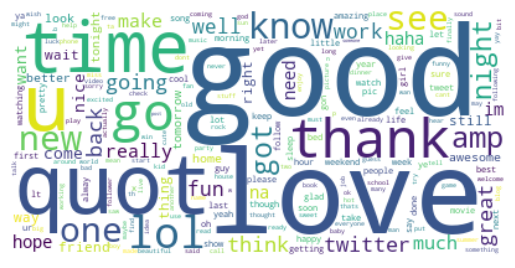

In [ ]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(positive_list)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Negative 

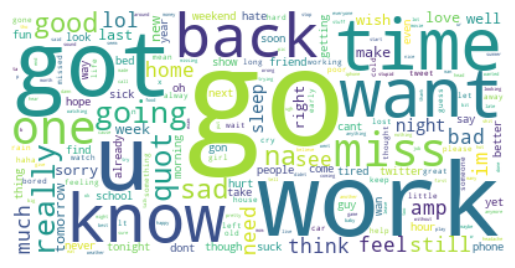

In [ ]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(negative_list)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Neutral

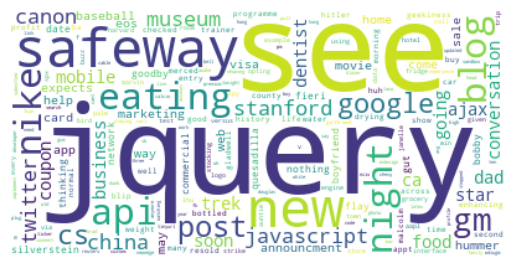

In [ ]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(neutral_list)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Decision Tree in Action: <a class="anchor" id="decision_tree"></a>

Decision trees are supervised methods. They need to be trained on some annotated data. Thus the general idea is the same as for any text classification:

Given a set of documents (for instance represented as TFIDF vectors) together with their labels, the algorithm will calculate which how much each word correlates with a particular label. It's role is to decipher the relationship between the feature and it's output label.

The tree might find that the word "amazing" often appears in documents labeled as positive. The word "bad" may mostly appears in negative documents. By combining such observations, we can build a model able to assign a label to any document. If we visualize our trained model, we can inteprete where it made a decision based on the significance of the word. In our training, we also expanded this logic to n-grams. If there is this sequence of words that occur together, this may correlate to a certain label. For example, we can create the tree below to deplict "where" the decisions are made.

In [ ]:
from sklearn import tree
y_pred[0]
text_representation = tree.export_text(clf_decision_tfidf)
print(text_representation)

Looking at a truncate version of our final tree (which recieved 70 validation accuracy, We can visualize where the tree is making the decision. The full decision tree: https://github.com/stwhitfield/ift6390_kaggle_2/blob/main/explainability_full_decision_tree

```
--- feature_1788918 <= 0.04
|   |--- feature_1586680 <= 0.02
|   |   |--- feature_1196283 <= 0.04
|   |   |   |--- feature_2298485 <= 0.04
|   |   |   |   |--- feature_1118931 <= 0.06
|   |   |   |   |   |--- feature_1329373 <= 0.03
|   |   |   |   |   |   |--- feature_680339 <= 0.05
|   |   |   |   |   |   |   |--- feature_1315838 <= 0.04
|   |   |   |   |   |   |   |   |--- feature_2229264 <= 0.04
|   |   |   |   |   |   |   |   |   |--- feature_748061 <= 0.02
|   |   |   |   |   |   |   |   |   |   |--- feature_2126182 <= 0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2484
|   |   |   |   |   |   |   |   |   |   |--- feature_2126182 >  0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 221
|   |   |   |   |   |   |   |   |   |--- feature_748061 >  0.02
|   |   |   |   |   |   |   |   |   |   |--- feature_277084 <= 0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9 ```


### A Concrete Example <a class="anchor" id="concrete_example"></a>


As our tree is very large, we can translate a small part of the subsection back into text features:


```  
tweet contains : "really" >  0.09
|   |   |   |--- tweet contain "not" > 0.14
|   |   |   |   |--- tweet contains "going" > 0.19
|   |   |   |   |   |   |   |   |   |--- class: negative ...
|   |   |   |--- tweet contains "miss" >  0.18
|   |   |   |   |   |   |   |   |--- class: positive
```


We can see where our tree makes a decision. 
On this particular tweet example, the difference between "negative" is indicated by the "not". The positive class is then indicated by a lack of presence of not.


`"I am really not going to class! It sucks!":` Negative 


`"I really miss you"`: Positive


It should be mentioned our tree had trouble generalizing to the small neutral class. If we look at a very small example below, we can see the key splitting criterion is "sad". Effectively, the tree is able to detect the words or n-grams (series of words") which hold the most significance to our output class. In this way, this is a highly explainable model but best fit for highly distinguishable classes.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer = CountVectorizer()
features = np.array(['happy', 'sad', 'depressed', 'sad', 'sad','bothered', 'sad'])
y = [0, 1, 1, 1, 1, 1, 1]
bag = vectorizer.fit_transform(features)
print(vectorizer.get_feature_names())
## Associate the indices with each unique word#
print(vectorizer.vocabulary_)
print(bag.toarray())

['bothered', 'depressed', 'happy', 'sad']
{'happy': 2, 'sad': 3, 'depressed': 1, 'bothered': 0}
[[0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]]


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
text_representation = tree.export_text(dt, feature_names=[1,2,3,4], show_weights=True)
print(text_representation)

|--- 3 <= 0.50
|   |--- weights: [0.00, 6.00] class: 1
|--- 3 >  0.50
|   |--- weights: [1.00, 0.00] class: 0



# BiLSTM in action <a class="anchor" id="biLSTM"></a>

Where we can build a Decision Tree and understand high-level it's decision (based on the branches), the BiLSTM is a more complex case. As we see below, we have an embeddings input layer, an lstm layer. We then have our global-max-polling and normalizing. 

We observed the training of this model was unstable and prone to overfit. We design our structure to account for this by adding dropout between the dense layers. The recurrent nature of LSTMs allows them to remember pieces of data that they have seen earlier in the sequence. The benefit we get from using the "bi" structure is we also have a sequence in the opposite direction as well. 


```
254585
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 embedding (Embedding)       (None, 32, 32)            8146752   
                                                                 
 lstm (LSTM)                 (None, 32, 280)           350560    
                                                                 
 global_max_pooling1d (Globa  (None, 280)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 280)              1120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 280)               0         
                                                                 
 dense (Dense)               (None, 10)                2810      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
=================================================================
Total params: 8,501,275
Trainable params: 8,500,715
Non-trainable params: 560
_________________________________________________________________
None
Epoch 1/25
1423/1423 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.7796
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/DataChallenge2/_model_1c.h5
1423/1423 [==============================] - 45s 26ms/step - loss: 0.4846 - accuracy: 0.7796 - val_loss: 0.4176 - val_accuracy: 0.8079
Epoch 2/25
1423/1423 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.8278
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/DataChallenge2/_model_1c.h5
1423/1423 [==============================] - 38s 27ms/step - loss: 0.3972 - accuracy: 0.8278 - val_loss: 0.4143 - val_accuracy: 0.8107
Epoch 3/25
1421/1423 [============================>.] - ETA: 0s - loss: 0.3485 - accuracy: 0.8531
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/DataChallenge2/_model_1c.h5
1423/1423 [==============================] - 39s 27ms/step - loss: 0.3485 - accuracy: 0.8531 - val_loss: 0.4352 - val_accuracy: 0.8088
Epoch 4/25
1422/1423 [============================>.] - ETA: 0s - loss: 0.3075 - accuracy: 0.8719
Epoch 4: saving model to /content/drive/MyDrive/Colab Notebooks/DataChallenge2/_model_1c.h5
1423/1423 [==============================] - 39s 27ms/step - loss: 0.3075 - accuracy: 0.8719 - val_loss: 0.4635 - val_accuracy: 0.8067 ````



While we can acheive highly accurate results (81%) on the validation set, it would be difficult to clearly explain what happens at every level due to the input we are using. We can explain how the input transforms in size but how much look-ahead and how much look-behind in the BI-LSTMs. 

# Less Explainable (Blackbox model)

In Bi-LSTM, we have one LSTM unrolling from left to right (say LSTM1) on the input (say X). We have another another LSTM unrolling form right to left (say LSTM2).

Out input is input size (X.shape) is `n X t X f` where

`n: Batch size`
`tsequence length/time-steps/no:of unrollings)`
`f: No:Of feature per time-step`


Assume that we have a model with single Bi-LSTM defined as below
`model.add(Bidirectional(LSTM(280, return_sequences=True), input_shape=(t, f)))`

In this case LSTM1 will return output of size `n X t X 280` and LSTM2 will return output of size `n X t X 280`

We combine the output of LSMT1 and LSTM2 at each time-step using merge_mode

`sum:` Add LSTM1 output to LSTM2 at each timestep. 

`ie. n X t X 280 of LSTM1 + n X t X 280 of LSTM2 = output of size n X t X 280`

We then conduct the following steps: 

1) mul: Element wise multiplication of LSTM1 output to LSTM2 at each timestep which will result in output of size n X t X 280

2) concat: Element wise concatenation of LSTM1 output to LSTM2 at each timestep which will result in output of size n X t X 280*2

3) Global Poooling + Batch Noramlization : Element wise average of LSTM1 output to LSTM2 at each timestep which will result in output of size n X t X 280
(Global pooling)

Dropout to prevent overfit.

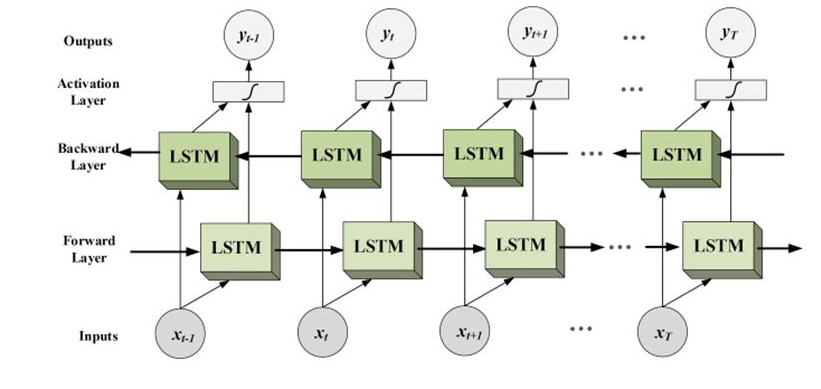

https://stackoverflow.com/questions/62991082/bidirectional-lstm-merge-mode-explanation


While we can visualize how the input is transformed, this model is a blackbox as tracing the input to output is non-trivial.

# Application <a class="anchor" id="application"></a> 

Our BiLSTM performed better on the Kaggle Competition. It harnessed "memory" units and was able to "look" forward and "look" backward than the decision tree. Understanding the output of the biLSTM is much more challenging than the Decision Tree. With the decision Tree at each branch, we can see where it split. We can see what "decision" it took using a concrete example. If we were to present these findings to a Practioner, it is possible they would prefer the output of the decision tree to the BiLSTM. This may be especially true for a healthcare related application or an engineer specific application. There will be cases where we prefer white-box solutions rather than blackbox.